In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 6.6 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=e98c9166ae4d0a352ff19091a9ca69208561dc2daab96c31e9dad3a13970dec8
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
#import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

In [ ]:
triveni = yf.download('TRIVENI.NS')

[*********************100%***********************]  1 of 1 completed


In [ ]:
class StockData():
  def __init__(self, ticker , ):
    self.data = pd.DataFrame([0])
    self.ticker = ticker
    self.download(ticker)
    self.transform()
    self.RSI(14)
    self.ATR(20)
    self.ATX(20)
    self.dropna(inplace=True)
    

  def download(self,ticker,Id=".NS"):
    if self.data == None:
      if type(ticker) == str:
        ticker = ticker + Id
        self.data = yf.download(ticker)
  def transform(self):
    
    self.data['HL_mid'] = (self.data['High'] + self.data['Low']) / 2
    self.data['OC_mid'] = (self.data['Open'] + self.data['Adj Close'])/2
    return

  def bollingerband(self):
    df = self.data.copy()
    df["MA"] = df['Adj Close'].rolling(20).mean()
    df["BB_up"] = df["MA"] + 2*df["MA"].rolling(20).std()
    df["BB_dn"] = df["MA"] - 2*df["MA"].rolling(20).std()
    df["BB_width"] = df["BB_up"] - df["BB_dn"]
    self.data['MA'] = df['MA']
    self.data['BB_width'] = df["BB_width"]
    return 
  def RSI(self,n):
    "function to calculate RSI"
    df = DF.copy()
    df['delta']=df['Adj Close'] - df['Adj Close'].shift(1)
    df['gain']=np.where(df['delta']>=0,df['delta'],0)
    df['loss']=np.where(df['delta']<0,abs(df['delta']),0)
    avg_gain = []
    avg_loss = []
    gain = df['gain'].tolist()
    loss = df['loss'].tolist()
    for i in range(len(df)):
        if i < n:
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i == n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        elif i > n:
            avg_gain.append(((n-1)*avg_gain[i-1] + gain[i])/n)
            avg_loss.append(((n-1)*avg_loss[i-1] + loss[i])/n)
    df['avg_gain']=np.array(avg_gain)
    df['avg_loss']=np.array(avg_loss)
    df['RS'] = df['avg_gain']/df['avg_loss']
    df['RSI'] = 100 - (100/(1+df['RS']))
    self.data['RSI'] = df['RSI']
    return 
  def ATR(self,n):
    df = self.data.copy()
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC']=abs(df['High']- df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']- df['Adj Close'].shift(1))
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1, skipna=False)
    self.data['ATR'] = df['TR'].rolling(n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    self.data['TR'] = df2['TR']
    return

  def ADX(self,n):
    "function to calculate ADX"
    df2 = self.data.copy()
     #the period parameter of ATR function does not matter because period does not influence TR calculation
    df2['DMplus']=np.where((df2['High']-df2['High'].shift(1))>(df2['Low'].shift(1)-df2['Low']),df2['High']-df2['High'].shift(1),0)
    df2['DMplus']=np.where(df2['DMplus']<0,0,df2['DMplus'])
    df2['DMminus']=np.where((df2['Low'].shift(1)-df2['Low'])>(df2['High']-df2['High'].shift(1)),df2['Low'].shift(1)-df2['Low'],0)
    df2['DMminus']=np.where(df2['DMminus']<0,0,df2['DMminus'])
    TRn = []
    DMplusN = []
    DMminusN = []
    TR = df2['TR'].tolist()
    DMplus = df2['DMplus'].tolist()
    DMminus = df2['DMminus'].tolist()
    for i in range(len(df2)):
        if i < n:
            TRn.append(np.NaN)
            DMplusN.append(np.NaN)
            DMminusN.append(np.NaN)
        elif i == n:
            TRn.append(df2['TR'].rolling(n).sum().tolist()[n])
            DMplusN.append(df2['DMplus'].rolling(n).sum().tolist()[n])
            DMminusN.append(df2['DMminus'].rolling(n).sum().tolist()[n])
        elif i > n:
            TRn.append(TRn[i-1] - (TRn[i-1]/14) + TR[i])
            DMplusN.append(DMplusN[i-1] - (DMplusN[i-1]/14) + DMplus[i])
            DMminusN.append(DMminusN[i-1] - (DMminusN[i-1]/14) + DMminus[i])
    df2['TRn'] = np.array(TRn)
    df2['DMplusN'] = np.array(DMplusN)
    df2['DMminusN'] = np.array(DMminusN)
    df2['DIplusN']=100*(df2['DMplusN']/df2['TRn'])
    df2['DIminusN']=100*(df2['DMminusN']/df2['TRn'])
    df2['DIdiff']=abs(df2['DIplusN']-df2['DIminusN'])
    df2['DIsum']=df2['DIplusN']+df2['DIminusN']
    df2['DX']=100*(df2['DIdiff']/df2['DIsum'])
    ADX = []
    DX = df2['DX'].tolist()
    for j in range(len(df2)):
        if j < 2*n-1:
            ADX.append(np.NaN)
        elif j == 2*n-1:
            ADX.append(df2['DX'][j-n+1:j+1].mean())
        elif j > 2*n-1:
            ADX.append(((n-1)*ADX[j-1] + DX[j])/n)
    self.data['ADX']=np.array(ADX)
    return 



In [ ]:

triveni['HL_mid'] = (triveni['High'] + triveni['Low']) / 2
triveni['OC_mid'] = (triveni['Open'] + triveni['Adj Close'])/2

#Bollinger_band_width
df = triveni.copy()
df["MA"] = df['Adj Close'].rolling(20).mean()
df["BB_up"] = df["MA"] + 2*df["MA"].rolling(20).std()
df["BB_dn"] = df["MA"] - 2*df["MA"].rolling(20).std()
df["BB_width"] = df["BB_up"] - df["BB_dn"]
triveni['MA'] = df['MA']
triveni['BB_width'] = df["BB_width"]


def RSI(DF,n):
    "function to calculate RSI"
    df = DF.copy()
    df['delta']=df['Adj Close'] - df['Adj Close'].shift(1)
    df['gain']=np.where(df['delta']>=0,df['delta'],0)
    df['loss']=np.where(df['delta']<0,abs(df['delta']),0)
    avg_gain = []
    avg_loss = []
    gain = df['gain'].tolist()
    loss = df['loss'].tolist()
    for i in range(len(df)):
        if i < n:
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i == n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        elif i > n:
            avg_gain.append(((n-1)*avg_gain[i-1] + gain[i])/n)
            avg_loss.append(((n-1)*avg_loss[i-1] + loss[i])/n)
    df['avg_gain']=np.array(avg_gain)
    df['avg_loss']=np.array(avg_loss)
    df['RS'] = df['avg_gain']/df['avg_loss']
    df['RSI'] = 100 - (100/(1+df['RS']))
    return df['RSI']

def ATR(DF,n):
  df = DF.copy()
  df['H-L'] = abs(df['High'] - df['Low'])
  df['H-PC']=abs(df['High']- df['Adj Close'].shift(1))
  df['L-PC']=abs(df['Low']- df['Adj Close'].shift(1))
  df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1, skipna=False)
  df['ATR'] = df['TR'].rolling(n).mean()
  df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
  return df2

def ADX(DF,n):
    "function to calculate ADX"
    df2 = DF.copy()
    df2['TR'] = ATR(df2,n)['TR'] #the period parameter of ATR function does not matter because period does not influence TR calculation
    df2['DMplus']=np.where((df2['High']-df2['High'].shift(1))>(df2['Low'].shift(1)-df2['Low']),df2['High']-df2['High'].shift(1),0)
    df2['DMplus']=np.where(df2['DMplus']<0,0,df2['DMplus'])
    df2['DMminus']=np.where((df2['Low'].shift(1)-df2['Low'])>(df2['High']-df2['High'].shift(1)),df2['Low'].shift(1)-df2['Low'],0)
    df2['DMminus']=np.where(df2['DMminus']<0,0,df2['DMminus'])
    TRn = []
    DMplusN = []
    DMminusN = []
    TR = df2['TR'].tolist()
    DMplus = df2['DMplus'].tolist()
    DMminus = df2['DMminus'].tolist()
    for i in range(len(df2)):
        if i < n:
            TRn.append(np.NaN)
            DMplusN.append(np.NaN)
            DMminusN.append(np.NaN)
        elif i == n:
            TRn.append(df2['TR'].rolling(n).sum().tolist()[n])
            DMplusN.append(df2['DMplus'].rolling(n).sum().tolist()[n])
            DMminusN.append(df2['DMminus'].rolling(n).sum().tolist()[n])
        elif i > n:
            TRn.append(TRn[i-1] - (TRn[i-1]/14) + TR[i])
            DMplusN.append(DMplusN[i-1] - (DMplusN[i-1]/14) + DMplus[i])
            DMminusN.append(DMminusN[i-1] - (DMminusN[i-1]/14) + DMminus[i])
    df2['TRn'] = np.array(TRn)
    df2['DMplusN'] = np.array(DMplusN)
    df2['DMminusN'] = np.array(DMminusN)
    df2['DIplusN']=100*(df2['DMplusN']/df2['TRn'])
    df2['DIminusN']=100*(df2['DMminusN']/df2['TRn'])
    df2['DIdiff']=abs(df2['DIplusN']-df2['DIminusN'])
    df2['DIsum']=df2['DIplusN']+df2['DIminusN']
    df2['DX']=100*(df2['DIdiff']/df2['DIsum'])
    ADX = []
    DX = df2['DX'].tolist()
    for j in range(len(df2)):
        if j < 2*n-1:
            ADX.append(np.NaN)
        elif j == 2*n-1:
            ADX.append(df2['DX'][j-n+1:j+1].mean())
        elif j > 2*n-1:
            ADX.append(((n-1)*ADX[j-1] + DX[j])/n)
    df2['ADX']=np.array(ADX)
    return df2['ADX']


triveni['RSI'] = RSI(triveni,14)
df = ADX(triveni,20)
triveni['ADX'] = df
triveni.dropna(inplace=True)
x = triveni[triveni.columns[4:]]
x1_scaled = x.to_numpy()


NameError: ignored

In [ ]:
x = pd.read_csv("/content/drive/MyDrive/Dataset/triveni.csv")
x.drop("Date",axis=1,inplace=True)
x1_scaled = x[1:].to_numpy()

In [ ]:
min_max_x = MinMaxScaler()
min_max_y = MinMaxScaler()
x1_scaled_x =min_max_x.fit_transform(x1_scaled[:,:-1])
x1_scaled_y = min_max_y.fit_transform([x1_scaled[:,-1]])

In [ ]:
x1_scaled = np.concatenate([x1_scaled_x,x1_scaled_y.T],axis=1)


In [ ]:
x1_scaled.shape

(3816, 8)

In [ ]:
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(dataset.shape[0]-step_size-1):
		a = dataset[i:(i+step_size),1:]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)
X,Y = new_dataset(x1_scaled,20)

X.shape


(3795, 20, 7)

In [ ]:
X[0]

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)
x_train,x_val,y_train,y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

In [ ]:
x_train= x_train[1:]
y_train = y_train[1:]
x_val = x_val[22:]
y_val = y_val[22:]

In [ ]:
len(x_val),len(x_train)

(320, 3072)

In [ ]:
y_train = y_train.reshape(y_train.shape[0],1)
y_train = y_train.astype(np.float32)
y_train.shape

(3072, 1)

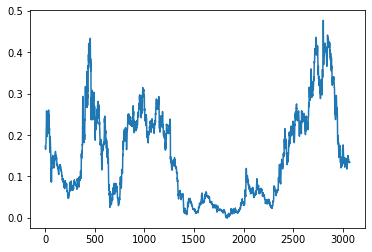

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(y_train)

In [ ]:
from torch.utils.data import Dataset
class CustomTimeSeries(Dataset):
    def __init__(self, x,y):
        x = np.reshape(x, (x.shape[0],1,x.shape[1],x.shape[2]))
        self.features = x.astype(np.float32)
        self.labels = y.astype(np.float32)
  

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.features[idx,:,:]
        y = self.labels[idx]
        return x, y
BATCH = 32

traindata = CustomTimeSeries(x_train,y_train)
train_dataloader = DataLoader(traindata, batch_size=BATCH, shuffle=False)
valdata = CustomTimeSeries(x_val,y_val)
val_dataloader = DataLoader(valdata, batch_size=BATCH, shuffle=False)

In [ ]:
for i,j in train_dataloader:
  
  break


In [ ]:
!pip install torchinfo


In [ ]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets 
from torchvision.transforms import ToTensor 
import os

#from torchinfo import summary

In [ ]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"available {device} device ")

device = torch.device(device)

class CNN_LSTM(nn.Module):
  def __init__(self,batch):
    super().__init__()
    
    self.batch = batch
    self.maxPool2d = nn.MaxPool2d(kernel_size=1)
    
    self.lstm_2 = nn.LSTM(input_size=32,hidden_size=32,num_layers=20)
    self.conv2d = nn.Conv2d(in_channels=1,out_channels=32, kernel_size=(8,1) )
    self.dense2 = nn.Linear(in_features=128, out_features=1)
    self.dropout = nn.Dropout(0.2)
    self.dense1 = nn.Linear(in_features=32, out_features=128)
    self.layerNorm = nn.LayerNorm(20)
    self.act1 = nn.ReLU()
    self.float()
    
  
  def forward(self, input_data):  #indicates pytorch how to manipulate the data
    
    input_data = self.layerNorm(input_data)
    x = self.conv2d(input_data)
    x = self.act1(x)
    x = self.maxPool2d(x)
    x = torch.reshape(x,(x.shape[0],32,20))

    y_p = x.permute(2,0,1)
    hx = torch.zeros(20,y_p.shape[1],32 ,dtype=y_p.dtype, device=input_data.device)
    cx = torch.zeros(20,y_p.shape[1] ,32,dtype=y_p.dtype, device=input_data.device)
    hx1 = torch.zeros(20,y_p.shape[1],32 ,dtype=y_p.dtype, device=input_data.device)
    cx1 = torch.zeros(20,y_p.shape[1] ,32,dtype=y_p.dtype, device=input_data.device)
    state1 = tuple((hx,cx))
    out,state = self.lstm_2(y_p,state1)
    state2 = (hx1,cx1)
    out,state = self.lstm_2(out,state2)
    #for i in range(y_p.shape[0]):
    #  hx, cx =self.lstm(y_p[i],(hx,cx))
    y_p = self.dense1(out[-1,:,:])
    y_p = self.dropout(y_p)
    y_p = self.act1(y_p)
    output = self.dense2(y_p)
    return output

def train_one_epoch(model, dataloader, loss_fn, optimiser, device, hidden):
  model.train()
  
  for inputs, targets in dataloader:
    inputs , targets = inputs.float(), targets.float()
    if device:
      inputs , targets = inputs.cuda(), targets.cuda()
    targets = targets.view(-1,1)

    # calculate loss
    preds = model(inputs)#hidden)
    #print(f"pred:{preds.shape},,, labels.shape:{targets.shape}")
    loss = loss_fn(preds,targets)

    # backpropagate loss and update weights
    optimiser.zero_grad()
    loss.backward(retain_graph=True)
    optimiser.step()
  print(f"train_loss : {loss.item()}")
  return loss.item()
  
def validation(model, dataloader, loss,hidden,device):
  losses = []
  model.eval()
  
  for inputs,targets in dataloader:
      inputs , targets = inputs.float(), targets.float()
      if device:
        inputs , targets = inputs.cuda(), targets.cuda()
      targets = targets.view(-1,1)
      # calculate loss
      preds = model(inputs)#,hidden)
      loss = loss_fn(preds,targets)
      losses.append(loss.item())
  print(f"val_loss_mean : {np.mean(losses)}")
  #print(f"val_losses : {losses}")
  return np.mean(losses)

def train(model, data_loader,dataloader_val, loss_fn, optimiser, device, epochs):
  val_loss = 0
  train_loss = 0 
  for i in range(epochs):
    hidden = (0,0)
    print(f"epoch {i+1}")
    train_loss = train_one_epoch(model, data_loader, loss_fn, optimiser, device,hidden)
    print("------------------------")
    print("validation score")
    
    if dataloader_val:
      hidden = (0,0)
      val_loss = validation(model,val_dataloader,loss_fn,device,hidden)
      if val_loss < train_loss:
        print("Validation_loss was Lower")

  print("training done")
  
  


available cuda device 


In [ ]:
class CNN_LSTM_2(nn.Module):
  def __init__(self,batch):
    super().__init__()
    self.batch = batch 
    
    self.lstm_hidden_size = 128
    self.lstm = nn.LSTMCell(input_size=64,hidden_size=self.lstm_hidden_size)
    self.lstm_2 = nn.LSTM(input_size=32,hidden_size=64,num_layers=20)

    self.conv2d = nn.Conv2d(in_channels=1,out_channels=32, kernel_size=(8,1))
    self.conv1d_1 = nn.Conv1d(in_channels = 1, out_channels= 32, kernel_size=2,dilation=2)
    self.conv1d_2 = nn.Conv1d(in_channels = 32, out_channels= 64, kernel_size=2,dilation=3)
    self.conv1d_2_2 = nn.Conv1d(in_channels = 64, out_channels= 64, kernel_size=2)
    self.conv1d_3 = nn.Conv1d(in_channels = 64, out_channels= 128, kernel_size=2)
    self.conv1d_4 = nn.Conv1d(in_channels = 128, out_channels= 128, kernel_size=2)
    self.maxPool2d = nn.MaxPool1d(kernel_size=1)

    
    self.act1 = nn.Tanh()
    self.dropout = nn.Dropout(0.2)
    self.dense_1 = nn.Linear(in_features=self.lstm_hidden_size, out_features=512)
    self.dense_2 = nn.Linear(in_features=512, out_features=64)
    self.dense_3 = nn.Linear(in_features=64, out_features=1)
  def forward(self,input):
      hidden=self.init_hidden()
      hx,cx = hidden
      hx,cx = hx.cuda(),cx.cuda()
      for k in range(input.shape[2]):
        x = self.act1(self.conv1d_1(input[:,:,k,:]))
        
        x = self.act1(self.conv1d_2(x))
        
        x = self.act1(self.conv1d_2_2(x))
        
        #x = self.act1(self.conv1d_3(x))
        #x = self.act1(self.conv1d_4(x))
        #x = self.act1(self.conv1d_4(x))
        x = x.view(self.batch,-1)
        hx,cx = self.lstm(x,(hx,cx))
      out = self.act1(self.dropout(self.dense_1(hx)))
      out = self.act1(self.dropout(self.dense_2(out)))
      out = self.dense_3(out)
      return out
  def backward(self, retain_variables=True):
        #Why is retain_variables True??
        self.loss.backward(retain_variables=retain_variables)
        return self.loss
  def init_hidden(self):
    hidden = (torch.zeros(self.batch,self.lstm_hidden_size ,dtype=torch.float32,requires_grad=True),
                   torch.zeros(self.batch,self.lstm_hidden_size ,dtype=torch.float32,requires_grad=True))
    return hidden

In [ ]:
model = CNN_LSTM_2(32)
model(input,(0,0))

In [ ]:
class CNN1D(nn.Module):
  def __init__(self,batch,hidden_size=64):
    super().__init__()
    self.batch = batch
    self.hidden_size= hidden_size
    self.conv1d_1 = nn.Conv1d(in_channels = 1, out_channels= 32, kernel_size=2,dilation=2)
    #self.maxpool = nn.MaxPool1d()
    self.conv1d_2 = nn.Conv1d(in_channels = 32, out_channels= 32, kernel_size=3,dilation=3)

    self.lstm = nn.LSTM(input_size=12,hidden_size=self.hidden_size,num_layers=32,batch_first=True,dropout=0.1)
    
    self.dense = nn.Linear(in_features=self.hidden_size,out_features=1)
    self.act1 = nn.ReLU()

  def forward(self,input):
    hidden = self.init_hidden()
    x = self.act1(self.conv1d_1(input))
    x = self.act1(self.conv1d_2(x))
    x,hidden = self.lstm(x,hidden)
    x = self.act1(self.dense(x))
    return x.view((self.batch,-1))
  def init_hidden(self,num_seq=32):
    hidden = (torch.zeros(self.batch,num_seq,self.hidden_size ,dtype=torch.float32,requires_grad=True),
                   torch.zeros(self.batch,num_seq,self.hidden_size ,dtype=torch.float32,requires_grad=True))
    return hidden

class CNN_combine(nn.Module):
   def __init__(self,batch,hidden_size=64):
    super().__init__()
    self.conv1 = CNN1D(batch)
    self.conv2 = CNN1D(batch)
    self.conv3 = CNN1D(batch)
    self.conv4 = CNN1D(batch)
    self.conv5 = CNN1D(batch)
    self.conv6 = CNN1D(batch)
    self.conv7 = CNN1D(batch)
    
   def forward(self,input):
    x1 = self.conv1(input[:,:,:,0])
    x2 = self.conv2(input[:,:,:,1])
    x3 = self.conv3(input[:,:,:,2])
    x4 = self.conv4(input[:,:,:,3])
    x5 = self.conv5(input[:,:,:,4])
    x6 = self.conv6(input[:,:,:,5])
    x7 = self.conv7(input[:,:,:,6])
    x = torch.cat((x1,x2,x3,x4,x5,x6,x7),axis=-1)
    return x 

class CNN_LSTM_3(nn.Module):
  def __init__(self,batch,hidden_size=64):
    super().__init__()
    self.batch = batch
    self.lstm_hidden_size = hidden_size
    self.conv1 = CNN_combine(batch) 
    self.dense = nn.Linear(in_features=224,out_features=1024)
    self.dense2 = nn.Linear(in_features = 1024, out_features = 1)
    self.act1 = nn.Tanh()
    self.drop = nn.Dropout(0.1)
  def forward(self,input,hidden):
    x = self.conv1(input)
    x = self.act1(self.drop(self.dense(x)))
    x = self.dense2(x)
    return x

  def backward(self, retain_variables=True):
        #Why is retain_variables True??
    self.loss.backward(retain_variables=retain_variables)
    return self.loss
  def init_hidden(self,num_seq=32):
    hidden = (torch.zeros(self.batch,num_seq,self.lstm_hidden_size ,dtype=torch.float32,requires_grad=True),
                   torch.zeros(self.batch,num_seq,self.lstm_hidden_size ,dtype=torch.float32,requires_grad=True))
    return hidden


In [ ]:
class CNN1D(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1d_1 = nn.Conv1d(in_channels = 1, out_channels= 32, kernel_size=2,dilation=1)  
    self.conv1d_2 = nn.Conv1d(in_channels = 1, out_channels= 32, kernel_size=2,dilation=2)
    self.conv1d_3 = nn.Conv1d(in_channels = 1, out_channels= 32, kernel_size=3,dilation=1)
    self.maxpool_2 = nn.MaxPool1d(2)
    self.act1 = nn.Tanh()
  def forward(self,input):
    x1 = self.act1(self.conv1d_1(input))
    x1 = self.maxpool_2(x1)
    x2 = self.act1(self.conv1d_2(input))
    x2 = self.maxpool_2(x2)
    x3 = self.act1(self.conv1d_3(input))
    x3 = self.maxpool_2(x3)
    x_1 = torch.cat((x1,x2,x3),axis=1)
    return x_1.view((32,96,1,9))


class CNN_2(nn.Module):
  def __init__(self,batch):
    super().__init__()
    self.batch = batch 
    self.conv1 = CNN1D()
    self.conv2 = CNN1D()
    self.conv3 = CNN1D()
    self.conv4 = CNN1D()
    self.conv5 = CNN1D()
    self.conv6 = CNN1D()
    self.conv7 = CNN1D()
    self.conv2d_1 = nn.Conv2d(in_channels=96,out_channels=32, kernel_size=3)
    self.conv2d_2 = conv2d_2 =nn.Conv2d(in_channels=1,out_channels=32, kernel_size=(16,1))
    self.maxPool2d = nn.MaxPool2d(kernel_size=2)
    self.act1 = nn.Tanh()
    self.dense_1= nn.Linear(in_features=512, out_features = 1024)
    self.dropout = nn.Dropout(0.2)
    self.dense_2 = nn.Linear(in_features=1024,out_features=512)
    self.dense_3 = nn.Linear(in_features=512, out_features = 64)
    self.dense_4 = nn.Linear(in_features=64, out_features=1)
    self.act1 = nn.LeakyReLU()
    self.act2 = nn.ReLU()
    self.bn1 = nn.BatchNorm2d(num_features=32)
    self.bn2 = nn.BatchNorm2d(num_features=32)
    self.conv2d_3 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=(2,4))
    
    self.maxPool2d = nn.MaxPool2d(4)

  def forward(self,input):
    x1 = self.conv1(input[:,:,:,0])
    x2 = self.conv2(input[:,:,:,1])
    x3 = self.conv3(input[:,:,:,2])
    x4 = self.conv4(input[:,:,:,3])
    x5 = self.conv5(input[:,:,:,4])
    x6 = self.conv6(input[:,:,:,5])
    x7 = self.conv7(input[:,:,:,6])
    x_1 = torch.cat((x1,x2,x3,x4,x5,x6,x7),axis=2)
    x_1 = self.act1(self.conv2d_1(x_1))
    
    x_2 = self.act1(self.conv2d_2(input))
    x_2 = self.bn2(x_2)
    x = torch.cat((x_1,x_2),axis=1)
    x = self.act1(self.conv2d_3(x))
    #x = self.maxPool2d(x)
    x = self.act1(self.dropout(self.dense_1(x.view(self.batch,-1))))
    x = self.act1(self.dropout(self.dense_2(x)))
    x = self.act1(self.dropout(self.dense_3(x)))
    x = self.dense_4(x)
    return x

In [ ]:


LEARNING_RATE = 1e-4

model = CNN_LSTM_2(BATCH)
model.cuda()


#summary(model, input_size=(BATCH, 1, 20, 7))

CNN_LSTM_2(
  (lstm): LSTMCell(64, 128)
  (lstm_2): LSTM(32, 64, num_layers=20)
  (conv2d): Conv2d(1, 32, kernel_size=(8, 1), stride=(1, 1))
  (conv1d_1): Conv1d(1, 32, kernel_size=(2,), stride=(1,), dilation=(2,))
  (conv1d_2): Conv1d(32, 64, kernel_size=(2,), stride=(1,), dilation=(3,))
  (conv1d_2_2): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
  (conv1d_3): Conv1d(64, 128, kernel_size=(2,), stride=(1,))
  (conv1d_4): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (maxPool2d): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (act1): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (dense_1): Linear(in_features=128, out_features=512, bias=True)
  (dense_2): Linear(in_features=512, out_features=64, bias=True)
  (dense_3): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
hidden = model.init_hidden()
out = model(input,hidden)

In [ ]:
POECHS = 50
LEARNING_RATE = 1e-4
loss_fn = nn.MSELoss()
if device=="cuda:0":
  model.cuda()
optimiser = torch.optim.Adamax(model.parameters()) #lr =LEARNING_RATE )

train(model, train_dataloader,test_dataloader, loss_fn, optimiser, device,EPOCHS)

epoch 1
train_loss : 0.0313371866941452
------------------------
validation score
val_loss_mean : 0.006221875332994386
Validation_loss was Lower
epoch 2
train_loss : 0.0010195438517257571
------------------------
validation score
val_loss_mean : 0.008883103559492156
epoch 3
train_loss : 0.00059405283536762
------------------------
validation score
val_loss_mean : 0.012764450046233833
epoch 4
train_loss : 0.0002497418608982116
------------------------
validation score
val_loss_mean : 0.012949497951194645
epoch 5
train_loss : 0.00031201273668557405
------------------------
validation score
val_loss_mean : 0.013807107671163976
epoch 6
train_loss : 0.001106102718040347
------------------------
validation score
val_loss_mean : 0.0010652014534571208
Validation_loss was Lower
epoch 7
train_loss : 0.00042499860865063965
------------------------
validation score
val_loss_mean : 0.00018920321126643104
Validation_loss was Lower
epoch 8
train_loss : 0.0006495320703834295
------------------------
v

In [ ]:
model(torch.tensor(x_train[2], dtype=torch.float32).view(1,1,x_train.shape[1],x_train.shape[2]),hidden)

In [ ]:
len(x_test)%32

28

In [ ]:
testdata = CustomTimeSeries(x_test[28:],y_test[28:])
test_dataloader = DataLoader(testdata, batch_size=BATCH, shuffle=False)

In [ ]:
model.eval()
model.cuda()
preds = []
for inputs,targets in train_dataloader:
  inputs , targets = inputs.float(), targets.float()
  if torch.cuda.is_available():
    inputs , targets = inputs.cuda(),targets.cuda()
  pred = model(inputs)#,hidden)
  preds.append(pred)
  
    
preq = []
for pred in preds:
   pred = pred.detach().numpy()
   pred = pred.tolist()
   preq = preq + pred 

TypeError: ignored

In [ ]:

   

#pred2 = min_max_y.inverse_transform(c)


NameError: ignored

In [ ]:
pred2 = min_max_y.inverse_transform(preq)

In [ ]:
!pip install torchinfo

In [ ]:

summary(model, input_size=(64, 1, 8, 20))

In [ ]:
#train(model, train_dataloader, loss_fn, optimiser, device, 15)
print("-------------")
print("Validation set losses")
validation(model, val_dataloader, loss_fn)

-------------
Validation set losses
val_loss_mean : 2055.8226318359375
val_losses : [917.4146728515625, 1090.14990234375, 2494.364501953125, 1866.8179931640625, 2264.697021484375, 3701.49169921875]


2055.8226318359375

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Models/Pytorch/CMM_LSTM_2_v6.pth")
print("Model Is trained")

Model Is trained


In [ ]:
model = CNN_LSTM_2(32)
state_dict = torch.load( "/content/drive/MyDrive/Models/Pytorch/CMM_LSTM_2_v6.pth")

model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
len(X[19:])%32

0

In [ ]:
data_xg = CustomTimeSeries(X[19:],Y[19:])
dataloader_full = DataLoader(data_xg, batch_size=BATCH, shuffle=False)

In [ ]:
model.eval()
preds = []
for inputs,targets in dataloader_full:
  inputs , targets = inputs.float(), targets.float()
  if torch.cuda.is_available() :
    inputs , targets = inputs.cuda(),targets.cuda()
  pred = model(inputs)#,hidden)
  preds.append(pred)
  
    
preq = []
for pred in preds:
   pred = pred.cpu().detach().numpy()
   pred = pred.tolist()
   preq = preq + pred 

In [ ]:
plt.rcParams["figure.figsize"] = (20,8)

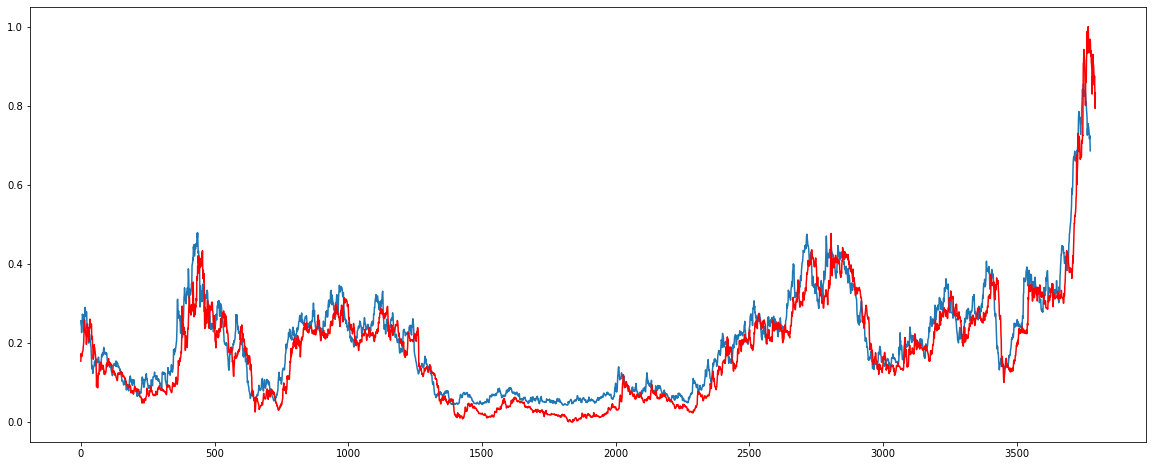

In [ ]:

plt.plot(preq[200],"-")

plt.plot(Y,"r")

In [ ]:
afor inputs,targets in train_dataloader:
      input , target = inputs.float(), targets.float()
      break

In [ ]:
model = CNN_2(32)
print(model(input).shape)

torch.Size([32, 1])


In [ ]:
batch = 32
lstm_hidden_size = 64
lstm = nn.LSTMCell(input_size=128,hidden_size=lstm_hidden_size,)
lstm_2 = nn.LSTM(input_size=6,hidden_size=64,num_layers=32,batch_first=True)

conv2d = nn.Conv2d(in_channels=96,out_channels=32, kernel_size=3)
conv2d_2 =nn.Conv2d(in_channels=1,out_channels=32, kernel_size=(16,1))



conv1d_2_2 = nn.Conv1d(in_channels = 64, out_channels= 64, kernel_size=2)
conv1d_3 = nn.Conv1d(in_channels = 64, out_channels= 128, kernel_size=2)
conv1d_4 = nn.Conv1d(in_channels = 128, out_channels= 128, kernel_size=2)
maxPool2d = nn.MaxPool2d(kernel_size=2)

m = nn.LayerNorm((20,7))
act1 = nn.ReLU()

dense = nn.Linear(in_features=128,out_features=1)


hx = torch.randn(batch,32,lstm_hidden_size)
cx = torch.randn(batch,32,lstm_hidden_size)
hide = (hx,cx)

conv1d_1 = nn.Conv1d(in_channels = 1, out_channels= 32, kernel_size=2,dilation=1)
conv1d_2 = nn.Conv1d(in_channels = 1, out_channels= 32, kernel_size=2,dilation=2)
conv1d_3 = nn.Conv1d(in_channels = 1, out_channels= 32, kernel_size=3,dilation=1)
maxpool_1 = nn.MaxPool1d(2)
maxpool_2 = nn.MaxPool1d(2)

print(input.shape)
x1 = act1(conv1d_1(input[:,:,:,0].view(32,1,20)))
x1 = maxpool_2(x1)
print(x1.shape)

x2 = act1(conv1d_2(input[:,:,:,0].view(32,1,20)))
x2 = maxpool_1(x2)
print(x2.shape)

x3 = act1(conv1d_3(input[:,:,:,0].view(32,1,20)))
x3 = maxpool_2(x3)
x_1 = torch.cat((x1,x2,x3),axis=1)
print(x3.shape)
x_1 = x_1.view((32,96,1,9))
#x2 = x2.view((32,32,1,9))
#x3 = x3.view((32,32,1,9))

x_1 = torch.cat((x_1,x_1,x_1,x_1,x_1,x_1,x_1),axis=2)
print(x_1.shape)
#x = conv1d_2(x)
x_1 = conv2d(x_1)
print(x.shape)
x_s = conv2d_2(input)
print(x_s.shape)
x = torch.cat((x_s,x_1),axis=1)
print(x.shape) 
conv2d_3 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=(2,4))
x = conv2d_3(x)
maxPool2d = nn.MaxPool2d(4)
#x = maxPool2d(x)
print(x.view((32,-1)).shape)
#x,hide = lstm_2(x,hide)
#
#x = torch.cat((x,x),axis=-1)
#print(x.shape)
#x = dense(x)
#print(x.view((32,-1)).shape)

torch.Size([32, 1, 20, 7])
torch.Size([32, 32, 9])
torch.Size([32, 32, 9])
torch.Size([32, 32, 9])
torch.Size([32, 96, 7, 9])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 5, 7])
torch.Size([32, 64, 5, 7])
torch.Size([32, 512])


In [ ]:
model = CNN_LSTM_3(batch=32)



In [ ]:
print(model(input))

tensor([[-0.0270],
        [-0.0381],
        [-0.0238],
        [-0.0468],
        [-0.0415],
        [-0.0344],
        [-0.0298],
        [-0.0195],
        [-0.0258],
        [-0.0355],
        [-0.0261],
        [-0.0384],
        [-0.0200],
        [-0.0293],
        [-0.0224],
        [-0.0337],
        [-0.0379],
        [-0.0402],
        [-0.0258],
        [-0.0425],
        [-0.0286],
        [-0.0431],
        [-0.0261],
        [-0.0335],
        [-0.0348],
        [-0.0305],
        [-0.0321],
        [-0.0331],
        [-0.0221],
        [-0.0372],
        [-0.0101],
        [-0.0297]], grad_fn=<AddmmBackward>)


In [ ]:
batch = BATCH
lstm_hidden_size = 64
lstm = nn.LSTMCell(input_size=128,hidden_size=lstm_hidden_size)
lstm_2 = nn.LSTM(input_size=32,hidden_size=64,num_layers=20)

conv2d = nn.Conv2d(in_channels=1,out_channels=32, kernel_size=(8,1))
conv1d_1 = nn.Conv1d(in_channels = 1, out_channels= 32, kernel_size=2)
conv1d_2 = nn.Conv1d(in_channels = 32, out_channels= 64, kernel_size=2)
conv1d_2_2 = nn.Conv1d(in_channels = 64, out_channels= 64, kernel_size=2)
conv1d_3 = nn.Conv1d(in_channels = 64, out_channels= 128, kernel_size=2)
conv1d_4 = nn.Conv1d(in_channels = 128, out_channels= 128, kernel_size=2)
maxPool2d = nn.MaxPool2d(kernel_size=1)

m = nn.LayerNorm((20,7))
act1 = nn.ReLU()

dense = nn.Linear(in_features=64, out_features=1)
inp = m(input)
print(inp.shape)
cons = []
hx = torch.randn(batch,lstm_hidden_size)
cx = torch.randn(batch,lstm_hidden_size)
output = torch.empty(batch)
for k in range(input.shape[2]):
  x = act1(conv1d_1(inp[:,:,k,:]))
  print(x.shape)
  x = act1(conv1d_2(x))
  x = act1(conv1d_2_2(x))
  x = act1(conv1d_3(x))
  x = act1(conv1d_4(x))
  x = act1(conv1d_4(x))
  x = x.view(32,-1)
  print(x.shape)
  hx,cx = lstm(x,(hx,cx))
  
out = dense(hx)
print(hx.shape)
out.shape


torch.Size([32, 1, 20, 7])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 32, 6])
torch.Size([32, 128])
torch.Size([32, 64])


torch.Size([32, 1])

In [ ]:
print(target.shape)

torch.Size([32, 1])


In [ ]:
print(h1.shape)
print(out.shape)
print(output.shape)
print(output2.shape)

torch.Size([20, 64, 64])
torch.Size([20, 64, 64])
torch.Size([64, 1])
torch.Size([64, 1])


In [ ]:
input = torch.tensor([0,1,23,3,4,5,55,67],dtype=torch.float32)
 # With Learnable Parameters
#input,_ = traindata[0]
#input = torch.tensor(input,dtype=torch.float32)
m = nn.LayerNorm(input.shape)

In [ ]:
out = m(input)
print(input)
print(input.shape)
print(out.tolist())
print(out.shape)

tensor([ 0.,  1., 23.,  3.,  4.,  5., 55., 67.])
torch.Size([8])
[-0.7921018600463867, -0.7519954442977905, 0.13034588098526, -0.6717826128005981, -0.631676197052002, -0.591569721698761, 1.4137513637542725, 1.8950284719467163]
torch.Size([8])


In [ ]:
'''
#inp = m(input)
map = conv2d(inp)
print(map.shape)
map = maxPool2d(map)
print(map.shape)
x =torch.reshape(map,(map.shape[0],32,20))
print(map.shape)
print(x.shape)
#y_p = x.permute(2,0,1)
y_p = x.view(20,1,32)
print(y_p.shape)
#hx = torch.randn(64,64)
#cx = torch.randn(64,64)
#output= []
#for k in range(y_p.shape[0]):
 # hx, cx = lstm(y_p[k],(hx,cx))
hx = torch.zeros(20,y_p.shape[1],64,dtype=y_p.dtype, device=device)
cx = torch.zeros(20,y_p.shape[1],64,dtype=y_p.dtype, device=device)
out,(h1,c1) = lstm_2(y_p)
output = dense(h1[-1,:,:])
output2 = dense(out[-1,:,:])'''

NameError: ignored

In [ ]:
train_one_epoch(model, train_dataloader, loss_fn, optimiser, device)
  